In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

quant = pd.read_csv("ravdess_quantitative.csv")
categ = pd.read_csv("ravdess_categorical.csv")
categ.vocal_channel = categ.estimated_vocal_channel
categ.drop(columns=["actor", "estimated_vocal_channel"], inplace=True)

quant=quant[categ.vocal_channel=="song"]
categ=categ[categ.vocal_channel=="song"]
categ.drop(columns=["vocal_channel"], inplace=True)

In [2]:
from sklearn.preprocessing import QuantileTransformer, StandardScaler, MinMaxScaler
from sklearn.metrics import silhouette_score, mutual_info_score, adjusted_mutual_info_score
scaler = MinMaxScaler()
X = scaler.fit_transform(quant.values)

In [3]:
import scipy.cluster.hierarchy as shc

plt.figure(figsize=(10, 7))

clusters = shc.linkage(X, 
            method='ward', 
            metric="euclidean")

<Figure size 1000x700 with 0 Axes>

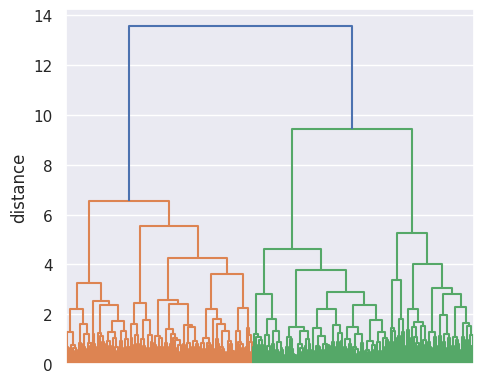

In [4]:
fig, ax = plt.subplots(figsize=(5,4))
shc.dendrogram(Z=clusters);
plt.xticks([])
plt.ylabel("distance")
plt.savefig("hier_DENDR.pdf")

In [5]:
ts = np.linspace(2.5,20, 20)
mi_df =pd.DataFrame(columns =["distance","category", "AMI", "n_clust", "sil"])
for cat in categ.columns:
    for t in ts:
        labels = shc.fcluster(clusters, t, criterion="distance")
        n_clust = len(np.unique(labels))
        amis = {}
        amis["distance"] = [t]
        amis["category"] = [cat]
        amis["AMI"] = [adjusted_mutual_info_score(labels, categ[cat])]
        if n_clust > 1:
            amis["sil"] = [silhouette_score(X, labels)]
        else:
            amis["sil"] = 0
        amis["n_clust"] = [n_clust]

        mi_df = pd.concat([mi_df, pd.DataFrame(amis)], ignore_index=True);

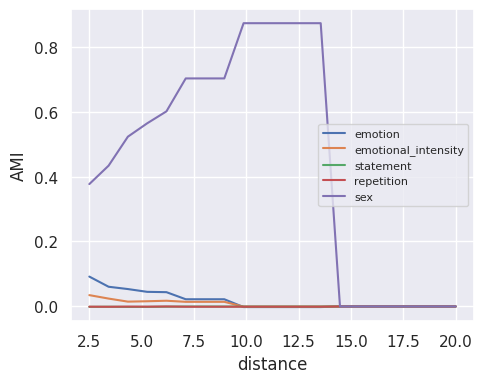

In [6]:
fig, ax = plt.subplots(figsize=(5,4))

sns.lineplot(data=mi_df, x="distance",y="AMI", hue="category")
plt.legend(fontsize=8)
plt.savefig("hier_MI.pdf")

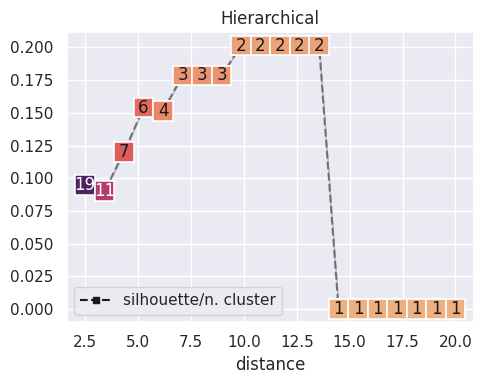

In [7]:
fig, ax = plt.subplots(figsize=(5,4))
from matplotlib.lines import Line2D

# sns.lineplot(data=mi_df, x="Ward distance", y="maxAMI", color="k", alpha=0.5)
# sns.lineplot(data=mi_df, x="Ward distance", y="noise population", color="k", alpha=0.5, ls=":")

sns.lineplot(data=mi_df, x="distance", y="sil", alpha=0.5, color= "k" , ls="--", zorder=1)
sns.scatterplot(data=mi_df, x="distance", y="sil", hue="n_clust", s=200, palette="flare", legend=False, marker="s", zorder=2)

for i, record in mi_df[mi_df.category=="sex"].iterrows():
    if record["n_clust"] > 10:
        color = "white"
    else:
        color="k"
    plt.annotate(str(int(record["n_clust"])), (record["distance"], record["sil"]), ha="center", va="center", color=color, zorder=3)



legend_elements = [#Line2D([0], [0], color='k', alpha=0.5, label='maxAMI'),
                    #Line2D([0], [0], color='k', alpha=0.5, ls=":", label='noise population'),
                   Line2D([0], [0], marker='s', color='k', ls="--" ,label='silhouette/n. cluster', markersize=5)]

ax.legend(handles=legend_elements)
plt.title("Hierarchical")
plt.ylabel("")
plt.savefig("hier_sil.pdf")

In [8]:
mi_df = pd.DataFrame(columns=["n_clust", "category", "AMI", "sil"])
for n_clust in np.arange(2, 22):
    for cat in categ.columns:

        labels = shc.fcluster(clusters, n_clust, criterion="maxclust")
        amis = {}
        amis["category"] = [cat]
        amis["AMI"] = [adjusted_mutual_info_score(labels, categ[cat])]
        if n_clust > 1:
            amis["sil"] = [silhouette_score(X, labels)]
        else:
            amis["sil"] = 0
        amis["n_clust"] = [n_clust]

        mi_df = pd.concat([mi_df, pd.DataFrame(amis)], ignore_index=True);

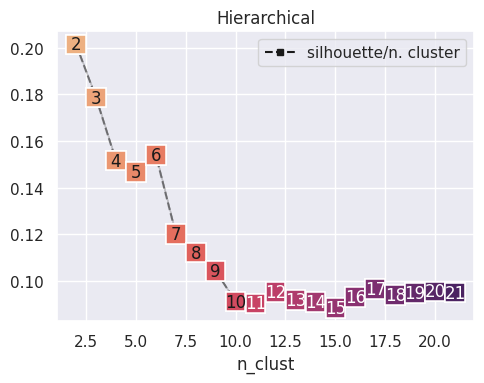

In [9]:
fig, ax = plt.subplots(figsize=(5,4))
from matplotlib.lines import Line2D

# sns.lineplot(data=mi_df, x="Ward distance", y="maxAMI", color="k", alpha=0.5)
# sns.lineplot(data=mi_df, x="Ward distance", y="noise population", color="k", alpha=0.5, ls=":")

sns.lineplot(data=mi_df, x="n_clust", y="sil", alpha=0.5, color= "k" , ls="--", zorder=1)
sns.scatterplot(data=mi_df, x="n_clust", y="sil", hue="n_clust", s=200, palette="flare", legend=False, marker="s", zorder=2)

for i, record in mi_df[mi_df.category=="sex"].iterrows():
    if record["n_clust"] > 10:
        color = "white"
    else:
        color="k"
    plt.annotate(str(int(record["n_clust"])), (record["n_clust"], record["sil"]), ha="center", va="center", color=color, zorder=3)



legend_elements = [#Line2D([0], [0], color='k', alpha=0.5, label='maxAMI'),
                    #Line2D([0], [0], color='k', alpha=0.5, ls=":", label='noise population'),
                   Line2D([0], [0], marker='s', color='k', ls="--" ,label='silhouette/n. cluster', markersize=5)]

ax.legend(handles=legend_elements)
plt.title("Hierarchical")
plt.ylabel("")
plt.savefig("hier_sil.pdf")

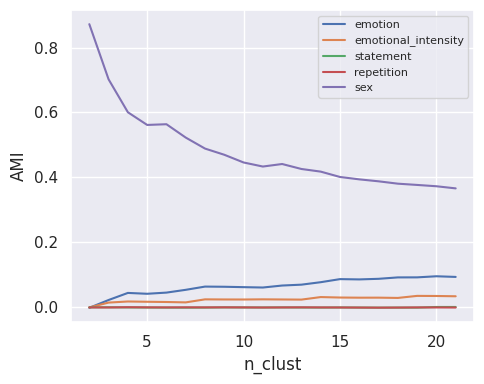

In [10]:
fig, ax = plt.subplots(figsize=(5,4))

sns.lineplot(data=mi_df, x="n_clust",y="AMI", hue="category")
plt.legend(fontsize=8)
plt.savefig("hier_MI.pdf")

In [11]:
from scipy.cluster.hierarchy import linkage, dendrogram

def my_plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

31
0.3293862205976131


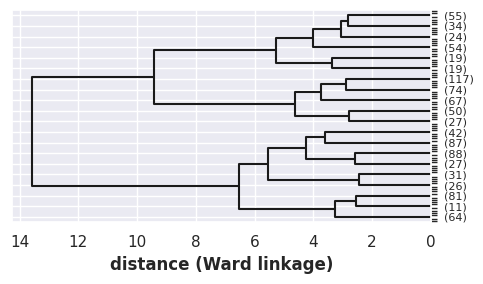

In [12]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import adjusted_mutual_info_score as ami
fig, ax = plt.subplots(figsize=(5, 3))
scaler = MinMaxScaler()
train_data = scaler.fit_transform(quant.values)
model = AgglomerativeClustering(n_clusters = None, distance_threshold=1.8, metric='euclidean', linkage='ward')
model = model.fit(train_data)
print(model.n_clusters_)
print(ami(model.labels_, categ.sex))

colors=sns.color_palette("flare", 300)
my_plot_dendrogram(model, truncate_mode="lastp", p=20, link_color_func= lambda k: "k", orientation="left")
# plt.xlim(2.25,1)
ax.tick_params(axis='y', which='major', labelsize=8)
ax.tick_params(axis='both', which='minor', labelsize=5)
ax.set_xlabel("distance (Ward linkage)", fontdict=dict(fontweight="bold"))
fig.tight_layout()
fig.savefig("dendrogram_agglomerative_ward.pdf")

4
0.2745888602069363


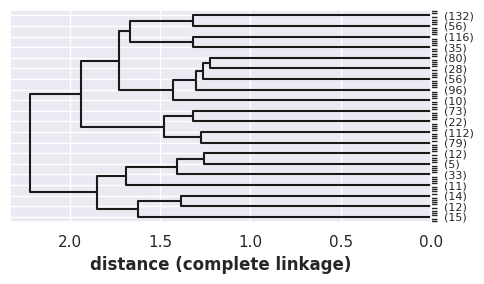

In [13]:
fig, ax = plt.subplots(figsize=(5, 3))
scaler = MinMaxScaler()
train_data = scaler.fit_transform(quant.values)
model = AgglomerativeClustering(n_clusters = None, distance_threshold=1.8, metric='euclidean', linkage='complete')
model = model.fit(train_data)
print(model.n_clusters_)
print(ami(model.labels_, categ.sex))

colors=sns.color_palette("flare", 300)
my_plot_dendrogram(model, truncate_mode="lastp", p=20, link_color_func= lambda k: "k", orientation="left")
# plt.xlim(2.25,1)
ax.tick_params(axis='y', which='major', labelsize=8)
ax.tick_params(axis='both', which='minor', labelsize=5)
ax.set_xlabel("distance (complete linkage)",fontdict=dict(fontweight="bold"))
fig.tight_layout()
fig.savefig("dendrogram_agglomerative_complete.pdf")

In [14]:
aggl_hier_df = pd.DataFrame()

for distance in np.linspace(0.1, 2.2, 20):
    model = AgglomerativeClustering(n_clusters = None, distance_threshold=distance, metric='euclidean', linkage='complete')
    model = model.fit(train_data)
    for feat in categ.columns:
        row = dict(distance=distance, sil=silhouette_score(train_data, model.labels_), n_clust=model.n_clusters_)
        row["AMI"] = ami(categ[feat], model.labels_)
        row["category"] = feat
        row = pd.DataFrame(row, index=[0])
        aggl_hier_df = pd.concat([aggl_hier_df, row], ignore_index=True)

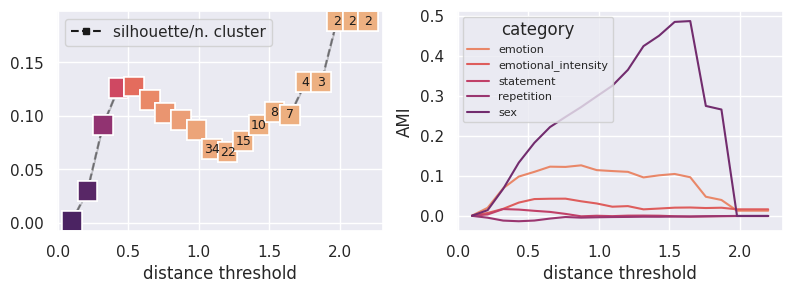

In [15]:
from matplotlib import rcParams
rcParams["figure.autolayout"] = False
# Sets default font
rcParams['font.size'] = 9.0
rcParams['font.family'] = "sans-serif"


fig, ax = plt.subplots(1,2,figsize=(8,3))
from matplotlib.lines import Line2D

# sns.lineplot(data=mi_df, x="Ward distance", y="maxAMI", color="k", alpha=0.5)
# sns.lineplot(data=mi_df, x="Ward distance", y="noise population", color="k", alpha=0.5, ls=":")

sns.lineplot(data=aggl_hier_df, x="distance", y="sil", alpha=0.5, color= "k" , ls="--", zorder=1, ax=ax[0])
sns.scatterplot(data=aggl_hier_df, x="distance", y="sil", hue="n_clust", s=200, palette="flare", legend=False, marker="s", zorder=2,ax=ax[0])

for i, record in aggl_hier_df[aggl_hier_df.category=="sex"].iterrows():
    if record["n_clust"] > 300:
        color = "white"
    else:
        color="k"
    if record.n_clust < 50:
        ax[0].annotate(str(int(record["n_clust"])), (record["distance"], record["sil"]), ha="center", va="center", color=color, zorder=3)



legend_elements = [#Line2D([0], [0], color='k', alpha=0.5, label='maxAMI'),
                    #Line2D([0], [0], color='k', alpha=0.5, ls=":", label='noise population'),
                   Line2D([0], [0], marker='s', color='k', ls="--" ,label='silhouette/n. cluster', markersize=5)]

ax[0].legend(handles=legend_elements)
ax[0].set_xlabel("distance threshold")
ax[0].set_ylabel("")

obj=sns.lineplot(data=aggl_hier_df, x="distance", y="AMI", hue="category", palette="flare", ax=ax[1])
sns.move_legend(obj,loc="upper left", fontsize=8)
ax[1].set_xlabel("distance threshold")
# sns.move_legend(obj, loc="center left", bbox_to_anchor=(1, 0.5))
# fig.subplots_adjust(top=, bottom=0.1, left=0.25, right=0.75)
fig.tight_layout()
fig.savefig("images/agglom_results.pdf")

<AxesSubplot: xlabel='log_kur', ylabel='mfcc_max'>

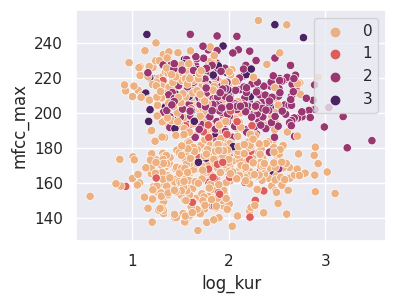

In [16]:
fig,ax = plt.subplots(figsize=(4,3))

model = AgglomerativeClustering(n_clusters = None, distance_threshold=1.8, metric='euclidean', linkage='complete')
model = model.fit(train_data)
sns.scatterplot(data=quant, x="log_kur", y = "mfcc_max", hue=model.labels_, palette="flare")